In [1]:
# Install required libs
# !pip install -U segmentation-models-pytorch Albumentations --user 

In [2]:
#!pip uninstall -y segmentation-models-pytorch

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = './sgsdataset/'

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'test')
y_valid_dir = os.path.join(DATA_DIR, 'testannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (Amentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (Amentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('.jpg','.png')) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [255]
        (print(self.class_values))
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

[255]


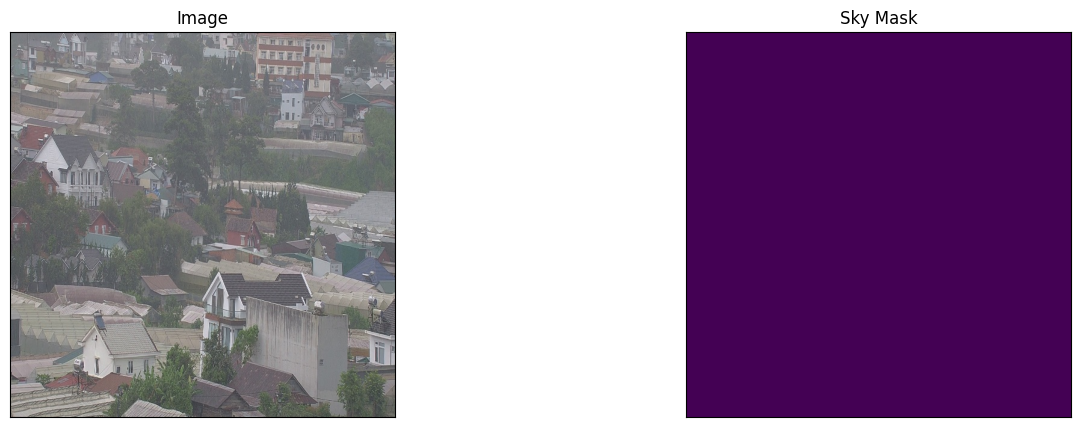

In [10]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['sky'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    sky_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Amentations**](https://github.com/A/Amentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/A/Amentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Amentations**](https://github.com/A/Amentations/) authors.

In [11]:
import albumentations as A

In [12]:
def get_training_augmentation(size = 224):
    train_transform = [

        A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally
        # A.Rotate(limit=15, p=0.5),  # Randomly rotate the image by up to 15 degrees
        A.RandomBrightnessContrast(p=0.2),  # Randomly adjust brightness and contrast
        A.RandomGamma(p=0.2),  # Randomly adjust gamma
        A.Blur(blur_limit=3, p=0.1),  # Randomly apply blur
        A.GaussNoise(var_limit=(1, 5), p=0.1),  # Randomly add Gaussian noise
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.GaussianBlur(blur_limit=3, p=0.1),
        ], p=0.2),  # Randomly choose one type of blur
        A.Resize(size, size),  # Resize the image to a fixed size
        # A.Normalize(), 
        ] # Normalize the image
    return A.Compose(train_transform)


def get_validation_augmentation(size = 224):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
       A.Resize(size, size)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: Amentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [13]:
# !pip uninstall imgaug -y && pip uninstall Amentations -y && pip install git+https://github.com/aleju/imgaug.git

/home/iec-ptit/.local/lib/python3.9/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]


[255]
[255]
[255]
[255]
[255]


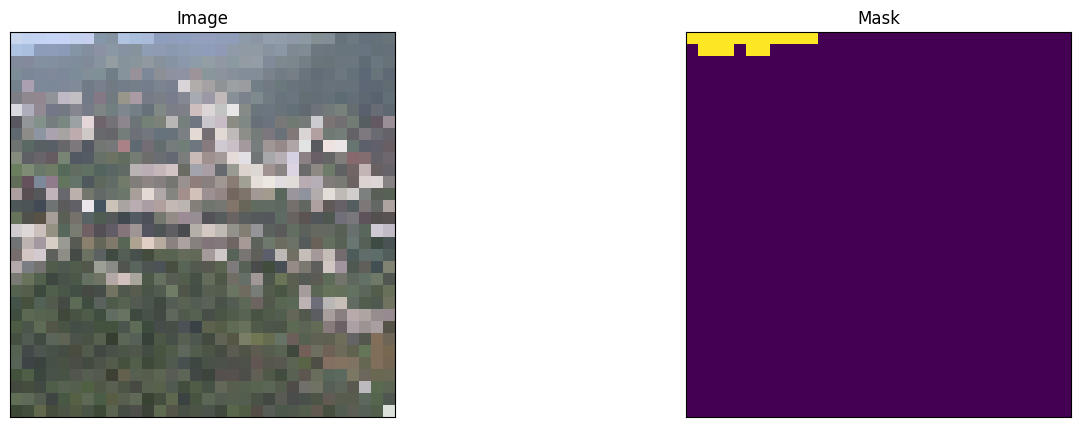

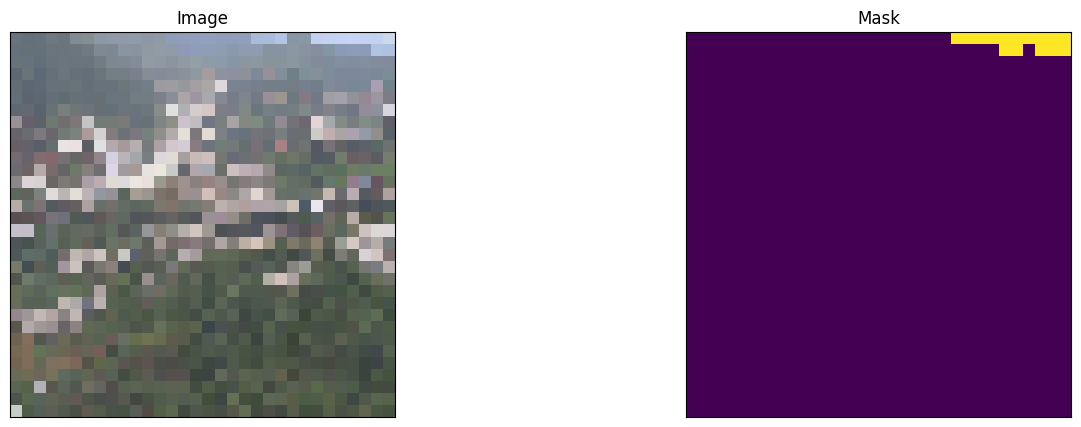

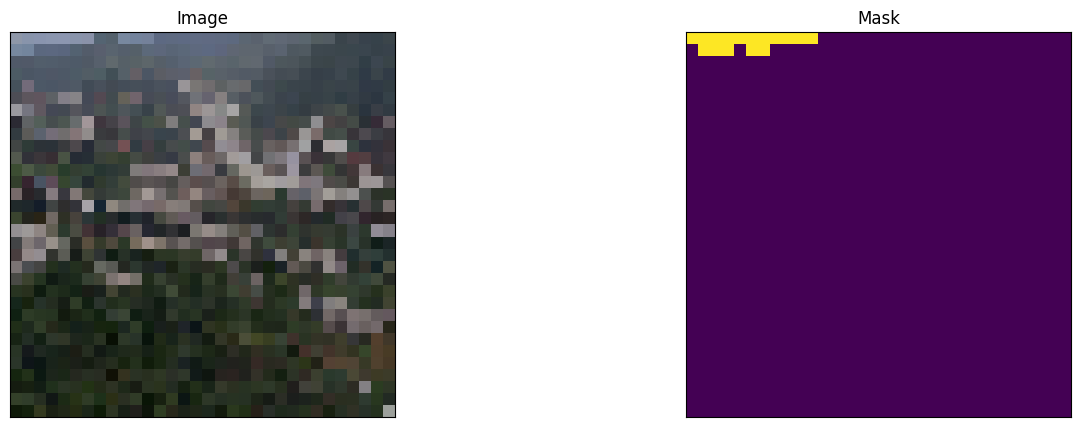

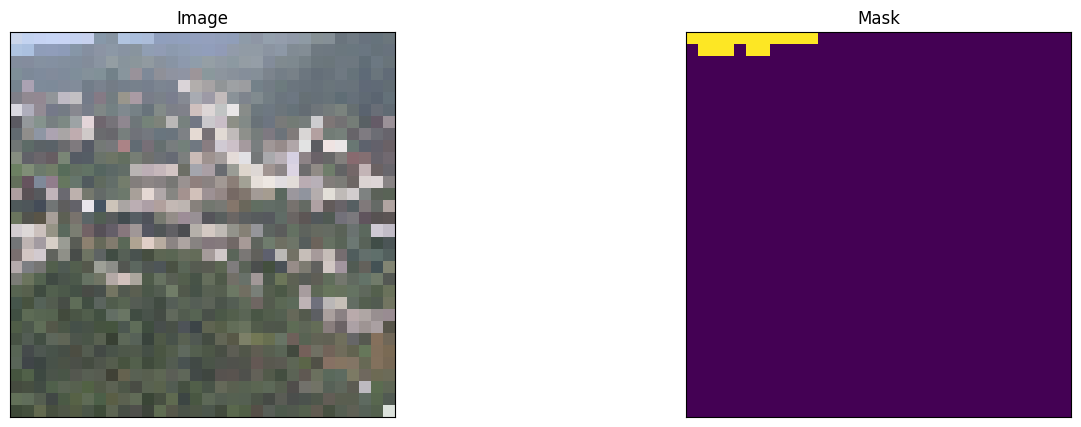

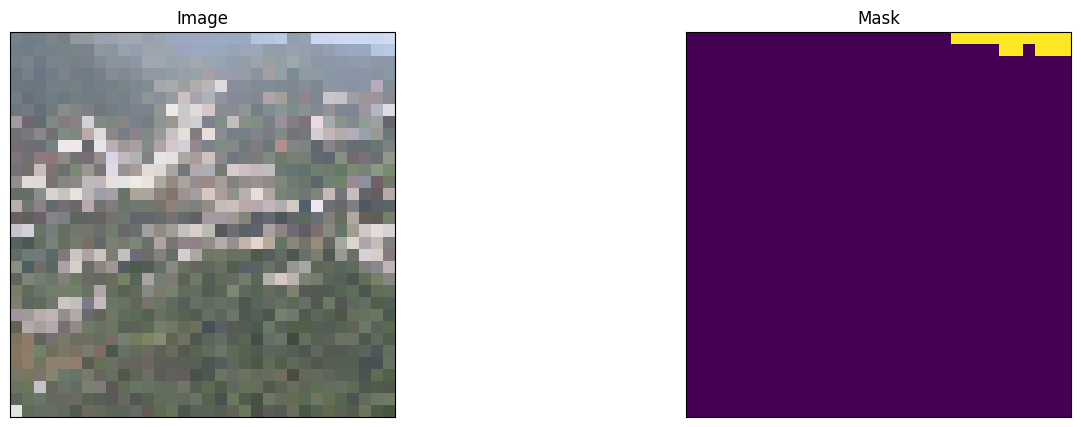

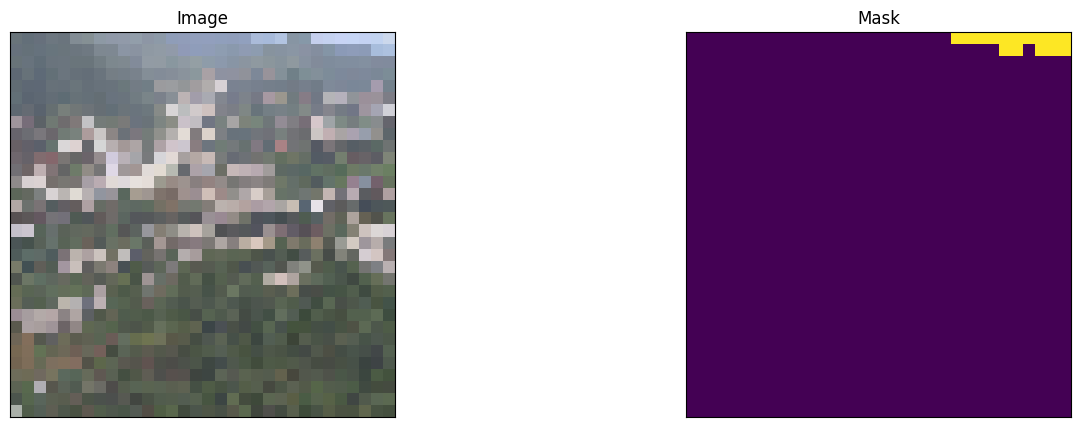

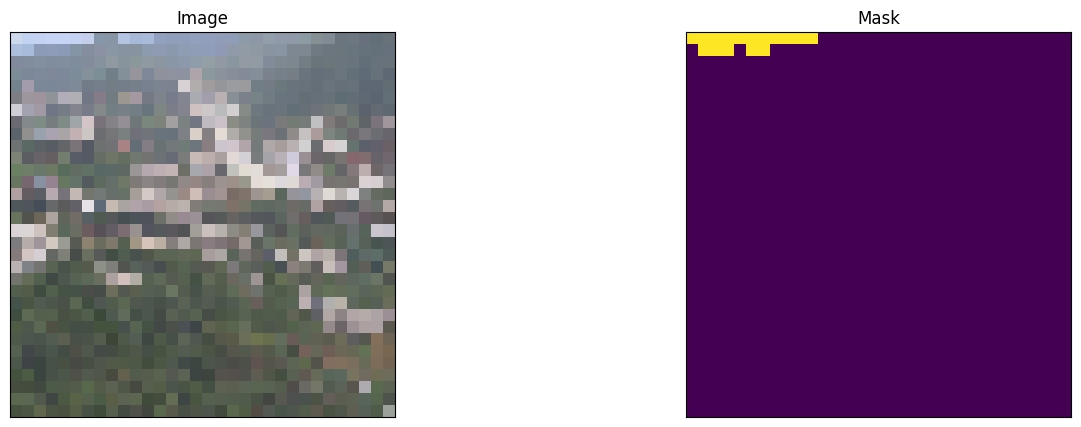

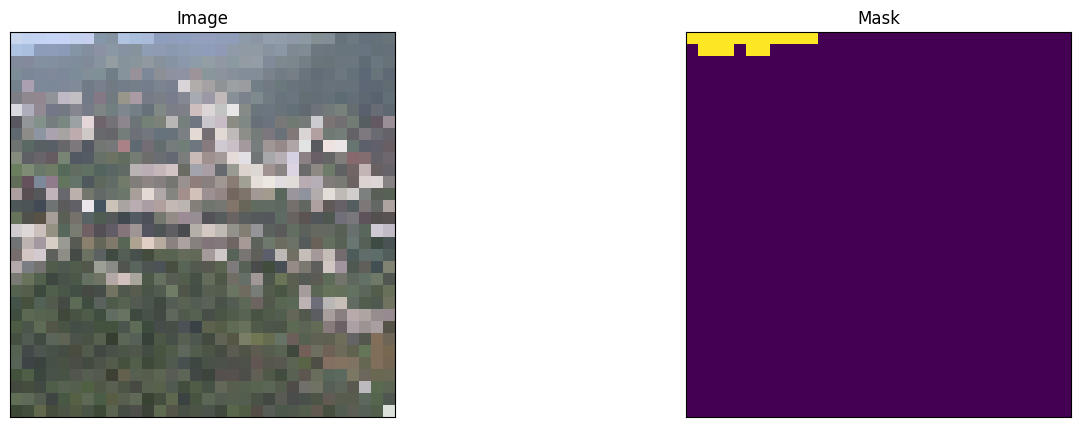

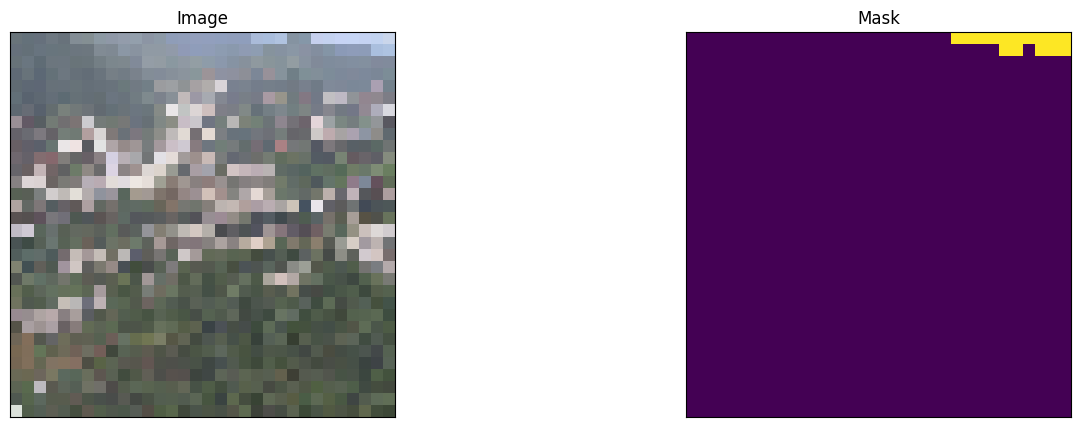

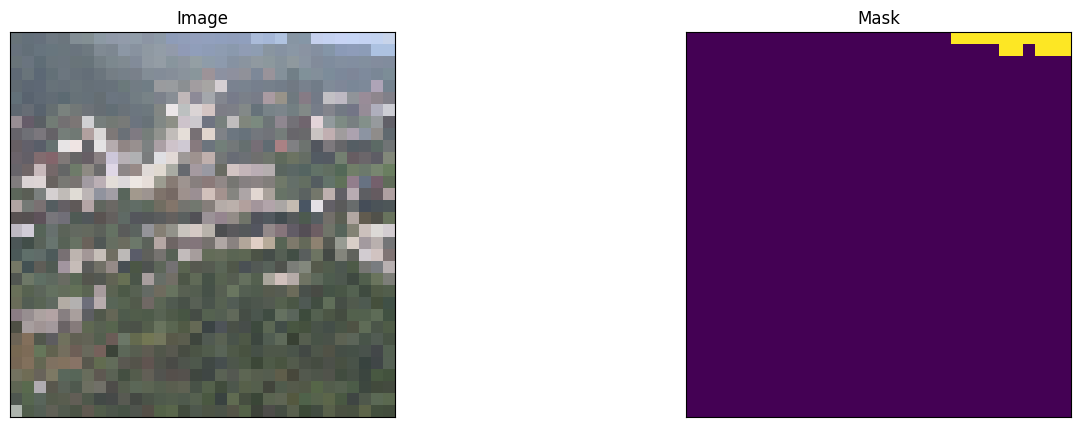

In [14]:
#### Visualize resulted augmented images and masks
augmented_dataset =[Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(size), 
    classes=['sky'],
) for size in range(32,641,32) ]
for i in range(10):
    image, mask = augmented_dataset[0][10]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

/home/iec-ptit/anaconda3/envs/segmentation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
ENCODER = 'timm-mobilenetv3_small_minimal_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['sky']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
pspnet = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
# create segmentation model with pretrained encoder
pan = smp.PAN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
unetplus2 = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
manet = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
linknet = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
deeplabv3 = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
deeplabv3plus = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
models = {'fpn':model,
          'pspnet':pspnet,
          'pan':pan,
          'unet':unet,
          'unetplus2':unetplus2,
          'manet':manet,
          'linknet':linknet,
          'deeplabv3':deeplabv3,
          'deeplabv3plus':deeplabv3plus,}

In [18]:
total_size = 0
# for model_name in models.keys():
#     model = models[model_name]
#     for param in model.parameters():
#         total_size += param.numel()
#     total_size_megabytes = total_size / (1024 ** 2)
#     print(f"{model_name}: {total_size_megabytes:.2f} MB")

In [19]:
model = models['fpn']

In [20]:
train_datasets = [Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(size), 
    preprocessing = get_preprocessing(preprocessing_fn),
    classes=['sky'],
) for size in range(32,641,32) ]

valid_datasets = [Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_validation_augmentation(size), 
    preprocessing = get_preprocessing(preprocessing_fn),
    classes=['sky'],
) for size in range(32,641,32) ]

train_loader = [DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=24) for train_dataset in train_datasets]
valid_loader = [DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=24) for valid_dataset in valid_datasets]

/home/iec-ptit/.local/lib/python3.9/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]


[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]
[255]


/home/iec-ptit/anaconda3/envs/segmentation/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
import segmentation_models_pytorch.utils.metrics

In [22]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [23]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
# num_of_exp = len(train_loader)
# for exp in [14,12,11]:
#     print(32+(32*(num_of_exp-exp-1)))

192
256
288


In [25]:
# train model for 40 epochs

num_of_exp = len(train_loader)
for exp in range(num_of_exp):
    max_score = 0
    for i in range(0, 40):
        print(f'./best_model_{32+(32*(num_of_exp-exp-1))}x{32+(32*(num_of_exp-exp-1))}.pth')
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader[num_of_exp-exp-1])
        valid_logs = valid_epoch.run(valid_loader[num_of_exp-exp-1])
        
        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, f'./models/best_model_{32+(32*(num_of_exp-exp-1))}x{32+(32*(num_of_exp-exp-1))}.pth')
            print('Model saved!')
            
        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')

./best_model_320x320.pth

Epoch: 0
train:   0%|          | 0/707 [00:00<?, ?it/s]

/home/iec-ptit/anaconda3/envs/segmentation/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid: 100%|██████████| 1414/1414 [00:31<00:00, 44.54it/s, dice_loss - 0.01839, iou_score - 0.9752]
Model saved!
./best_model_320x320.pth

Epoch: 1
valid: 100%|██████████| 1414/1414 [00:31<00:00, 45.01it/s, dice_loss - 0.01384, iou_score - 0.9818]
Model saved!
./best_model_320x320.pth

Epoch: 2
valid: 100%|██████████| 1414/1414 [00:31<00:00, 44.83it/s, dice_loss - 0.01189, iou_score - 0.9838]
Model saved!
./best_model_320x320.pth

Epoch: 3
valid: 100%|██████████| 1414/1414 [00:31<00:00, 44.99it/s, dice_loss - 0.009993, iou_score - 0.9854]
Model saved!
./best_model_320x320.pth

Epoch: 4
valid: 100%|██████████| 1414/1414 [00:31<00:00, 44.76it/s, dice_loss - 0.00974, iou_score - 0.9857] 
Model saved!
./best_model_320x320.pth

Epoch: 5
valid: 100%|██████████| 1414/1414 [00:31<00:00, 45.04it/s, dice_loss - 0.008893, iou_score - 0.9867]
Model saved!
./best_model_320x320.pth

Epoch: 6
valid: 100%|██████████| 1414/1414 [00:31<00:00, 45.05it/s, dice_loss - 0.00875, iou_score - 0.9866] 
./best_m

: 

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
import onnx